## Support Vector Machines (SVM)

## Outline:
- [Introduction](#intro)
- [Section One](#section-1): Mathematical Formalism + Kernal Tricks
- [Section Two](#section-2): Simple Example
- [Section Three](#section-3): Visualisation - margins, support vectors for each combo
- [Section Four](#section-4): Vary parameters

Keywords: SVM, Regularization Parameters, 

<hr style="border:2px solid gray">
<a name="intro"></a>

## Introduction to SVM [^](#outline)

SVMs are amongst the most used of all ML techniques. They can be used in classification or regression, although generally more the former. Again [{homl}](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) is very clear in describing these and I recommend their description.

This is based largely on the idea of geometically solving classification problems using optimisation. Binary classification will be the main focus of this notebook but it is important to note that (with considerable work) they can be generalised to multi-class problems too. 

If your feature space has N dimensions then the SVM finds an $N-1$ dimensional (hyper)surface to optimally seperate samples that now belong to two different classes. This is posed as optimisation as we are trying to optimise the paramters that define the hypersurface. 

## Linear SVM Classifiers

For linear SVM classifiers the hypersurface we are finding will be a hyperplane, So for example in 2D it will find a line and in 3D it will find a plane. 

Lets consider two linearly seperable data sets. For this example we will take a subset of our iris data. This is a slight reworking of how it is described in **{homl}** (Page 155-156):

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:,(2,3)]# petal length, petal width. (this slice is equivalent to X = iris["data"][:,2:4])
y = iris["target"]
setosa_or_versicolor = (y == 0) | (y == 1) # we only want y-values of 0 or 1. | is the bitwise OR operator.
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

Below we visualise our data, and plot two lines which separate the two classes. As we will see, just because a line separates our data, it is not necessarily the optimal separator. 

**Note:** this is not SVM, as we are just plotting two lines which seperate our data.

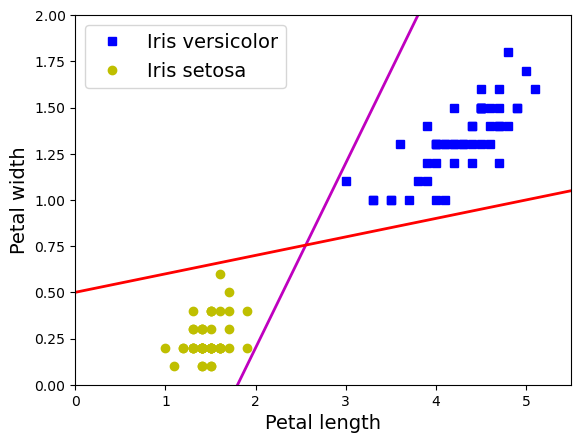

In [4]:
#Here we are plotting petal length against petal width
x0 = np.linspace(0, 5.5, 200)

pred_1 = x0 - 1.8
pred_2 = 0.1 * x0 + 0.5

plt.plot(x0, pred_1, "m-", linewidth=2)
plt.plot(x0, pred_2, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()


While you can see that either of the above lines separate the current two different iris types, some data points are right on the limit/boundary of the lines and it is possible that more data of either sort of iris will cross the boundary and be incorrectly classified. So this model is said to not generalise well, as it may not perform well on new instances.

In an SVM you try to find the line that provides the **greatest separation**. An intuitive explanation is to think in 2D and then generalise this. First we find the two points in our training data which are classified diffrently but are closest together. Then, a line connecting them is drawn and a *perpendicular bisector* is drawn halfway between the two points. This line is now the line seperating the iris types. We will do this below:

In [18]:
from sklearn.svm import SVC

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=1e6)
svm_clf.fit(X, y)

SVC(C=1000000.0, kernel='linear')

`C` is called the **regularization parameter**, and must be a *strictly positive float*. Decreasing C corresponds to more regularization (putting more weight on the cost function). This is discussed more later, but for now we set C to be a very large number, such that it is effectively infinite.

Now lets plot the result:

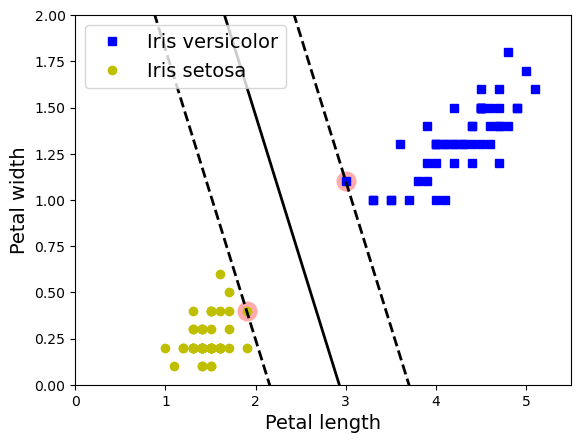

In [19]:
x0 = np.linspace(0, 5.5, 200)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)

# retrieve the slope and the intercept
w = svm_clf.coef_[0]
b = svm_clf.intercept_[0]

# At the decision boundary, w0*x0 + w1*x1 + b = 0    ==>    x1 = -w0/w1 * x0 - b/w1
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

# now look at the margins
margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

# now get the actual support vectors
svs = svm_clf.support_vectors_

# now draw the lines
plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)
plt.axis([0, 5.5, 0, 2])

plt.show()

You can see that the SVM has chosen the line that has the greatest separation. The two marked points are located at the *edge of the street* and are the closest instances from each class.These are the actual **support vectors**, don't be fooled by this 2D example, these are position vectors, not coordinates (position vectors with respect to the origin). 

One point noted in **{homl}** is that SVM can very sensitive to feature scale. In the example below (taken from **{homl}**) you can see the difference the preprocessor scaling can make.

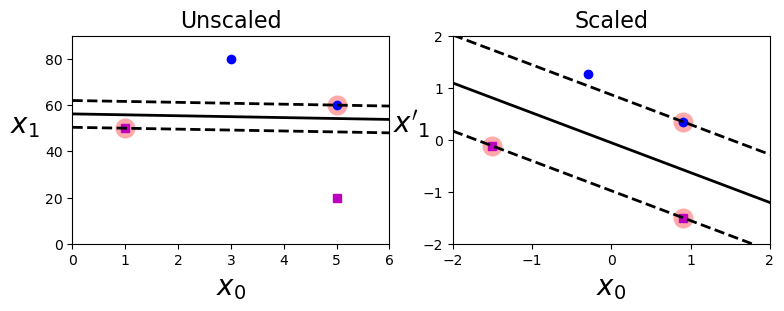

In [7]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear")
svm_clf.fit(Xs, ys)



def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)
    
plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

# Now use the sklearn preprocessor to scale the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

plt.show()

You can see that Scaled plot looks a lot more healthy.

## Soft Margin Classification

What we have been doing so far is call hard margin classification. This has two significant problems. Firstly, the problem has to be linearly separable and secondly it is very sensitive to outliers. Lets see what we get if we introduce outliers into our iris dataset. 

In [ ]:
X_mod=X
X_mod=np.append(X,[[3.5,1.2]], axis=0)
y_mod=np.append(y,0)

#fit the new model and plot
svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X_mod, y_mod)

x0 = np.linspace(0, 5.5, 200)

plt.plot(X_mod[:, 0][y_mod==1], X_mod[:, 1][y_mod==1], "bs", label="Iris versicolor")
plt.plot(X_mod[:, 0][y_mod==0], X_mod[:, 1][y_mod==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)

# retrieve the slope and the intercept
w = svm_clf.coef_[0]
b = svm_clf.intercept_[0]

# At the decision boundary, w0*x0 + w1*x1 + b = 0
# => x1 = -w0/w1 * x0 - b/w1
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

# now look at the margins
margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

# now get the actual support vectors
svs = svm_clf.support_vectors_

# now draw the lines
plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)
plt.axis([0, 5.5, 0, 2])

plt.show()

You can see that these data are no longer linearly separable and there is margin violation. There is a hyperparameter **C** than can be tune the behaviour of the SVM in these cases.  C is a regularistion coefficient that you can use to control this behaviour. C must always be positive but can be very small or very large. The default value of C is one.

<div style="background-color:#C2F5DD">

## Exercise

This is to familiarise yourselves to how `C` works. Take the code above, add a few more "outliers" and then plot the results for C going from small values (say 0.0001) to quite large values (say 1000000) and try to understand the behaviour.

# Nonlinear SVM Classification

Not all problems involve datasets which are linearly separable. However, many of these datasets do become linearly separable if you add features with higher polynomial terms (as we did with nonlinear regression). The most common straightforward example of this (and you see it in all the text books) is something like: 

In [ ]:
x0 = np.linspace(0, 5.5, 200)

pred_1 = x0 - 1.8
pred_2 = 0.1 * x0 + 0.5

plt.plot(x0, pred_1, "m-", linewidth=2)
plt.plot(x0, pred_2, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()


Each datapoint has one feature, and currently this dataset is not linearly separable. However, it will become linearly separable if add a second feature that is the square of the first. Mathematically, we want to add a feature $x_2 = (x_1)^2$

<div style="background-color:#C2F5DD">

## Exercise

Actually go through the exercise of showing this works using `PolynomialFeatures`. 
Run the cell below to see documentation for `PolynomialFeatures`.

In [ ]:
from IPython.display import IFrame
IFrame("https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#", width=900, height=800)